In [1]:
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

In [3]:
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0
...,...,...,...,...,...,...,...,...,...
16995,-124.3,40.6,52.0,2217.0,394.0,907.0,369.0,2.4,111400.0
16996,-124.3,40.7,36.0,2349.0,528.0,1194.0,465.0,2.5,79000.0
16997,-124.3,41.8,17.0,2677.0,531.0,1244.0,456.0,3.0,103600.0
16998,-124.3,41.8,19.0,2672.0,552.0,1298.0,478.0,2.0,85800.0


In [51]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

In [40]:
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
1935,-117.3,33.0,30.0,2750.0,555.0,1281.0,520.0,4.7,286900.0
1566,-117.2,33.2,17.0,3675.0,672.0,1693.0,597.0,3.4,190800.0
11751,-121.3,38.0,48.0,1112.0,227.0,583.0,216.0,2.3,77600.0
5323,-118.2,34.7,36.0,2696.0,454.0,1192.0,452.0,4.0,116300.0
3179,-117.8,33.8,14.0,1458.0,423.0,615.0,365.0,4.3,218800.0
...,...,...,...,...,...,...,...,...,...
4239,-118.0,33.9,35.0,1065.0,176.0,574.0,171.0,5.0,200800.0
4571,-118.1,34.2,38.0,2726.0,398.0,1059.0,380.0,7.2,410400.0
5663,-118.2,33.9,44.0,2137.0,461.0,1126.0,439.0,3.4,172900.0
5733,-118.2,34.0,43.0,1682.0,422.0,1706.0,409.0,2.1,153300.0


In [6]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]
    ]
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"]
    )
    return processed_features

In [7]:
preprocess_features(california_housing_dataframe)

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
1935,33.0,-117.3,30.0,2750.0,555.0,1281.0,520.0,4.7,2.1
1566,33.2,-117.2,17.0,3675.0,672.0,1693.0,597.0,3.4,2.2
11751,38.0,-121.3,48.0,1112.0,227.0,583.0,216.0,2.3,1.9
5323,34.7,-118.2,36.0,2696.0,454.0,1192.0,452.0,4.0,2.3
3179,33.8,-117.8,14.0,1458.0,423.0,615.0,365.0,4.3,2.4
...,...,...,...,...,...,...,...,...,...
4239,33.9,-118.0,35.0,1065.0,176.0,574.0,171.0,5.0,1.9
4571,34.2,-118.1,38.0,2726.0,398.0,1059.0,380.0,7.2,2.6
5663,33.9,-118.2,44.0,2137.0,461.0,1126.0,439.0,3.4,1.9
5733,34.0,-118.2,43.0,1682.0,422.0,1706.0,409.0,2.1,1.0


In [8]:
def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets["median_house_value"] = (
        california_housing_dataframe["median_house_value"] / 1000.0
    )
    return output_targets

In [9]:
preprocess_targets()

TypeError: preprocess_targets() missing 1 required positional argument: 'california_housing_dataframe'

In [10]:
preprocess_targets(california_housing_dataframe)

,median_house_value
1935,286.9
1566,190.8
11751,77.6
5323,116.3
3179,218.8
...,...
4239,200.8
4571,410.4
5663,172.9
5733,153.3


In [11]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))

In [12]:
training_examples

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
1935,33.0,-117.3,30.0,2750.0,555.0,1281.0,520.0,4.7,2.1
1566,33.2,-117.2,17.0,3675.0,672.0,1693.0,597.0,3.4,2.2
11751,38.0,-121.3,48.0,1112.0,227.0,583.0,216.0,2.3,1.9
5323,34.7,-118.2,36.0,2696.0,454.0,1192.0,452.0,4.0,2.3
3179,33.8,-117.8,14.0,1458.0,423.0,615.0,365.0,4.3,2.4
...,...,...,...,...,...,...,...,...,...
3587,33.8,-117.9,33.0,2729.0,549.0,2223.0,535.0,4.0,1.2
9729,36.6,-119.6,33.0,1589.0,294.0,1102.0,307.0,2.0,1.4
1618,33.2,-117.2,34.0,544.0,108.0,348.0,127.0,4.1,1.6
15942,37.8,-122.4,52.0,2459.0,507.0,1012.0,475.0,4.1,2.4


In [13]:
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2637.5,537.8,1429.4,500.2,3.9,2.0
std,2.1,2.0,12.6,2161.2,420.3,1145.6,382.2,1.9,1.1
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1460.8,295.0,788.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2125.5,432.0,1165.0,409.0,3.6,1.9
75%,37.7,-118.0,37.0,3149.2,645.0,1722.0,603.0,4.8,2.3
max,41.9,-114.5,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


In [43]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,207.5
std,115.2
min,15.0
25%,120.7
50%,181.3
75%,265.0
max,500.0


In [44]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,207.5
std,115.2
min,15.0
25%,120.7
50%,181.3
75%,265.0
max,500.0


In [16]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))

In [17]:
prediction_examples.describe()

NameError: name 'prediction_examples' is not defined

In [18]:
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2658.4,543.3,1429.9,503.6,3.9,2.0
std,2.1,2.0,12.5,2224.5,424.5,1153.3,390.0,1.9,1.2
min,32.6,-124.3,2.0,18.0,3.0,8.0,4.0,0.5,0.2
25%,33.9,-121.7,18.0,1465.8,300.0,793.0,282.0,2.5,1.5
50%,34.2,-118.5,29.0,2136.0,437.0,1171.0,409.0,3.5,2.0
75%,37.7,-118.0,37.0,3154.5,658.0,1718.0,610.2,4.7,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,28566.0,6082.0,15.0,52.0


In [19]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

In [20]:
validation_targets.describe()

,median_house_value
count,5000.0
mean,206.8
std,117.9
min,15.0
25%,117.1
50%,177.4
75%,264.8
max,500.0


In [21]:
plt.figure(fixsize=(13,8))

TypeError: __init__() got an unexpected keyword argument 'fixsize'

In [22]:
plt.figure(figsize=(13,8))

<Figure size 936x576 with 0 Axes>

<Figure size 936x576 with 0 Axes>

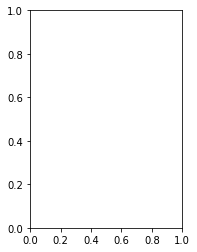

In [23]:
ax = plt.subplot(1,2,1)

In [24]:
ax.set_title("validation data")

Text(0.5,1,'validation data')

In [25]:
ax.set_autoscaley_on(False)

In [26]:
ax.set_ylim([32])

ValueError: not enough values to unpack (expected 2, got 1)

In [27]:
ax.set_ylim([32, 43])

(32, 43)

In [28]:
ax.set_autoscalex_on(False)

In [29]:
help(ax.a)

Help on method set_xlim in module matplotlib.axes._base:

set_xlim(left=None, right=None, emit=True, auto=False, **kw) method of matplotlib.axes._subplots.AxesSubplot instance
    Set the data limits for the x-axis
    
    .. ACCEPTS: (left: float, right: float)
    
    Parameters
    ----------
    left : scalar, optional
        The left xlim (default: None, which leaves the left limit
        unchanged).
    
    right : scalar, optional
        The right xlim (default: None, which leaves the right limit
        unchanged).
    
    emit : bool, optional
        Whether to notify observers of limit change (default: True).
    
    auto : bool or None, optional
        Whether to turn on autoscaling of the x-axis. True turns on,
        False turns off (default action), None leaves unchanged.
    
    xlimits : tuple, optional
        The left and right xlims may be passed as the tuple
        (`left`, `right`) as the first positional argument (or as
        the `left` keyword argu

In [30]:
ax.set_xlim([-126, -112])

(-126, -112)

In [31]:
help(plt.scatter)

Help on function scatter in module matplotlib.pyplot:

scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None, hold=None, data=None, **kwargs)
    A scatter plot of *y* vs *x* with varying marker size and/or color.
    
    Parameters
    ----------
    x, y : array_like, shape (n, )
        The data positions.
    
    s : scalar or array_like, shape (n, ), optional
        The marker size in points**2.
        Default is ``rcParams['lines.markersize'] ** 2``.
    
    c : color, sequence, or sequence of color, optional, default: 'b'
        The marker color. Possible values:
    
        - A single color format string.
        - A sequence of color specifications of length n.
        - A sequence of n numbers to be mapped to colors using *cmap* and
          *norm*.
        - A 2-D array in which the rows are RGB or RGBA.
    
        Note that *c* should not be a single numeric RGB or RGBA seque

ValueError: c of shape (1200,) not acceptable as a color sequence for x with size 12000, y with size 12000

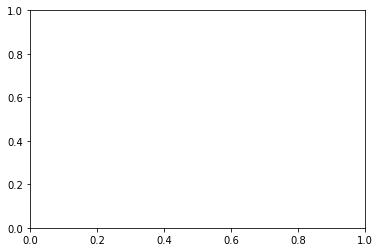

In [32]:
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())

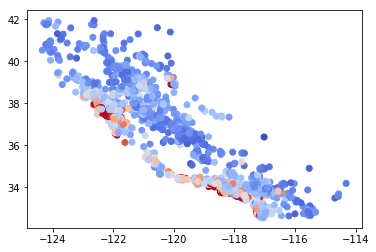

In [33]:
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

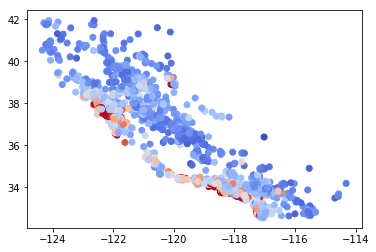

In [35]:
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ValueError: c of shape (1200,) not acceptable as a color sequence for x with size 12000, y with size 12000

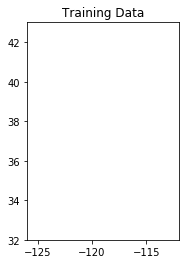

In [36]:
ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())

In [37]:
training_targets["median_house_value"].describe()

count   1200.0
mean     209.3
std      111.6
min       30.0
25%      123.4
50%      183.9
75%      266.7
max      500.0
Name: median_house_value, dtype: float64

In [38]:
training_targets["median_house_value"].describe()

count   1200.0
mean     209.3
std      111.6
min       30.0
25%      123.4
50%      183.9
75%      266.7
max      500.0
Name: median_house_value, dtype: float64

ValueError: c of shape (1200,) not acceptable as a color sequence for x with size 12000, y with size 12000

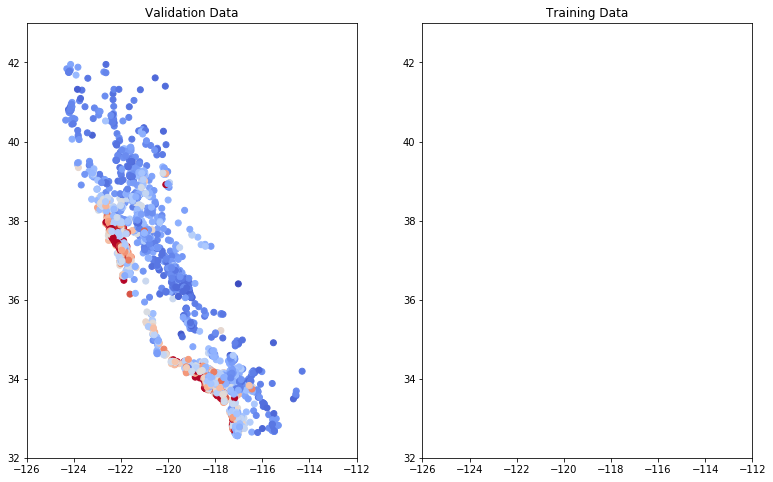

In [39]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())
_ = plt.plot()

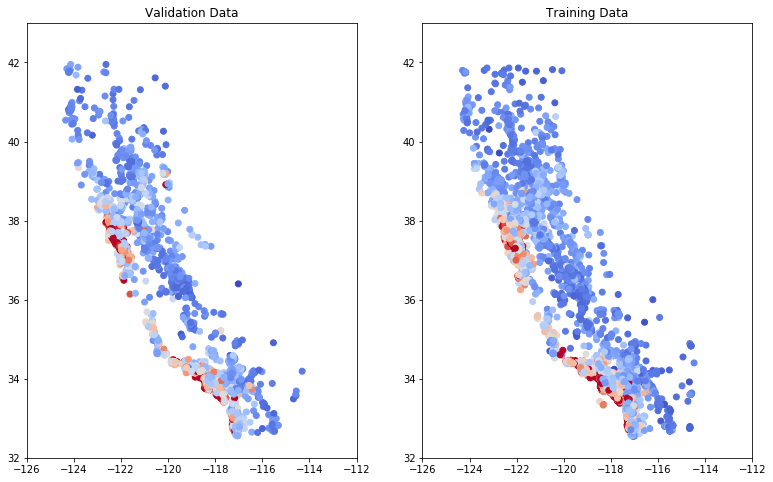

In [46]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())
_ = plt.plot()

In [47]:
training_examples.describe()
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2658.4,543.3,1429.9,503.6,3.9,2.0
std,2.1,2.0,12.5,2224.5,424.5,1153.3,390.0,1.9,1.2
min,32.6,-124.3,2.0,18.0,3.0,8.0,4.0,0.5,0.2
25%,33.9,-121.7,18.0,1465.8,300.0,793.0,282.0,2.5,1.5
50%,34.2,-118.5,29.0,2136.0,437.0,1171.0,409.0,3.5,2.0
75%,37.7,-118.0,37.0,3154.5,658.0,1718.0,610.2,4.7,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,28566.0,6082.0,15.0,52.0


In [48]:
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2637.5,537.8,1429.4,500.2,3.9,2.0
std,2.1,2.0,12.6,2161.2,420.3,1145.6,382.2,1.9,1.1
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1460.8,295.0,788.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2125.5,432.0,1165.0,409.0,3.6,1.9
75%,37.7,-118.0,37.0,3149.2,645.0,1722.0,603.0,4.8,2.3
max,41.9,-114.5,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


In [49]:
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2658.4,543.3,1429.9,503.6,3.9,2.0
std,2.1,2.0,12.5,2224.5,424.5,1153.3,390.0,1.9,1.2
min,32.6,-124.3,2.0,18.0,3.0,8.0,4.0,0.5,0.2
25%,33.9,-121.7,18.0,1465.8,300.0,793.0,282.0,2.5,1.5
50%,34.2,-118.5,29.0,2136.0,437.0,1171.0,409.0,3.5,2.0
75%,37.7,-118.0,37.0,3154.5,658.0,1718.0,610.2,4.7,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,28566.0,6082.0,15.0,52.0


[]

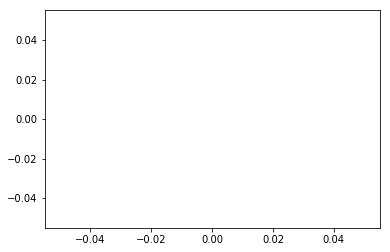

In [52]:
plt.plot()

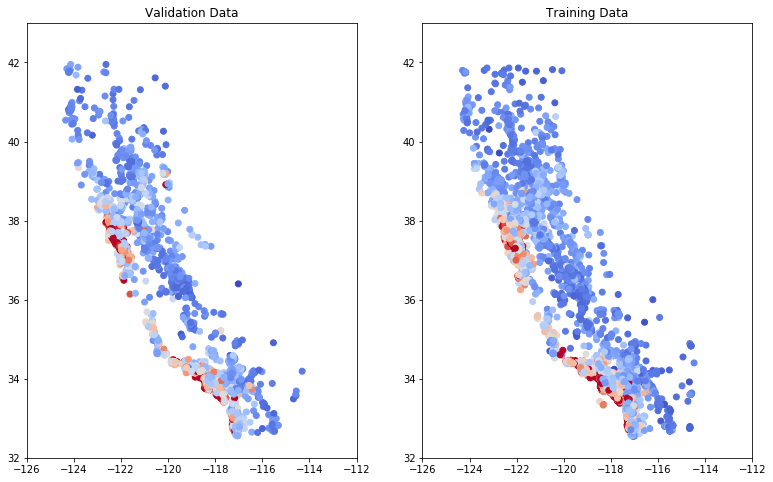

In [53]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())
_ = plt.plot()

In [54]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [55]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])